In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy import *
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import os,sys
if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"
sys.path.append(repo_path)

from basics import *

from DropRecapture import drop_recapture_MC

tau = 2*pi

# System

Ensemble of single atoms trapped in an optical dipole trap of trap depth $U_0$ and trap frequencies $\omega_t$, $\omega_a$, at a temperature $T$, Illuminated by counter propagating Rydberg beams of wavelengths $\lambda_1$, $\lambda_2$. Rydberg rabi frequency is $\Omega$ and can be estimated outside this notebook

## Doppler Shift

$$\Delta_d(\mathbf{v}) = \frac{\mathbf{\Delta k}\cdot \mathbf{v}}{2\pi}$$

taking $\mathbf{k} = k \hat{\mathbf{z}}$ and ignoring transverse velocity components $\mathbf{v} = v \hat{\mathbf{z}}$:

$$\Delta_d(v) = \frac{\Delta k}{2\pi} v$$

## Velocity distribution

The atom ensemble will be in a Maxwell-Boltzmann distribution, with a spread in velocity in v of 

$$\sigma_v  = \sqrt{\frac{k_b T}{m_{cs}}} $$

and a probability density function in velocity

$$\rho (v) = \frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-v^2}{2\sigma^2}}$$

The average value of any measurable quantity ($O(v)$) over the thermal distribution can be determined via integration

$$\bar{O} = \int_{-\infty}^\infty dv \rho(v) O(v)$$

## Rabi oscillations

A two level system under periodic perturbation can be treated with the RWA to produce a two-level Hamiltonian:

$$H = \begin{bmatrix}
    0 & \Omega/2 \\
    \Omega/2 & \Delta
\end{bmatrix}$$

Where $\Omega$ is the rabi frequency of the driven system and $\Delta$ is the detuning of the driving field(s) from the system's resonance.

In the case of a ladder excitation this form for the Hamiltonian holds (after adiabatic elimination has been applied), save for a global phase shift that will be omitted from these computations.

These Rabi oscillations can be measured by measuring the population of the excited (rydberg) or ground state. These populations are:

$$\rho_{rr}[\Omega,\Delta](t) = P_r[\Omega,\Delta](t) = \frac{\Omega^2}{\Omega^2+\Delta^2}\sin^2(\sqrt{\Omega^2+\Delta^2}t/2)$$
$$\rho_{gg}[\Omega,\Delta](t) = P_g[\Omega,\Delta](t) = 1-\rho_{rr}[\Omega,\Delta](t)$$

By substituting $\Delta = \Delta_0 + \Delta_d(v)$, where $\Delta_0$ is the detuning of the laser from the bare transition in the lab frame, and $\Delta_d(v)$ is the doppler shift an atom moving at velocity $v$ experiences, the above equations can be averaged over the ensemble. This averaging uncovers the dephasing effect doppler shifts due to finite atom temperature have on the rydberg fidelity.

$$\bar{P}_{r}[\Omega,\Delta_0](t) = \int_{-\infty}^{\infty} dv \rho(v)P_{r}[\Omega,\Delta(v)](t)$$

This integral is tough to do by hand but trivial to perform numerically. The results of that numerical integration are displayed in this notebook

In [5]:
# System parameters

## Hybrid Rydberg wavelengths (m)
l1 = 684e-9
l2 = 595e-9

## AQUA Rydberg wavelengths (m)
l1 = 459e-9
l2 = 1038e-9

# \Delta k (1/m)
dk = abs(tau*(1/l1-1/l2))

# Hard-coded estimate of Rabi frequency (2\pi x Hz)
O = tau*1e6
tpi = tau/O

# Initial Laser detuning (2\pi x Hz)
D0 = 0

# Atom Temperature (K)
T = 30e-6

# Maxwell-Boltzmann spread in velocity (m/s)
sigv = sqrt(kb*T/mcs)

# Velocity PDF
rhov = lambda v,s: 1/s/sqrt(tau)*exp(-v**2/2/s**2)

# Population in Rydberg state
Pr0 = lambda t,v,Delta0 : O**2/(O**2+(Delta0+doppler_shift(dk,v))**2)*sin(sqrt(O**2+(Delta0+doppler_shift(dk,v))**2)*t/2)**2

# compute doppler shift for beam(s) with (\delta)k-vector k
def doppler_shift(k,v):
    return k*v/tau

In [6]:
def plot_oscillations(t,pr,delta0,temp):
    title = f"T = {temp*1e6:.0f}$\mu K$\n$\Delta_0/\Omega = {delta0/O:.1f}$"
    xlabel = "Rydberg Pulse time ($\mu s$)"
    fig,ax = plt.subplots(1,1)
    ax.plot(t*1e6,Pr0(t,0,delta0))
    ax.plot(t*1e6,pr)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("$P_r(t)$")
    fig.show()

    fig,ax = plt.subplots(1,1)
    ax.plot(tlin*1e6,Pr-Pr0(tlin,0,delta0))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Doppler induced pulse error")
    fig.show()

<IPython.core.display.Javascript object>


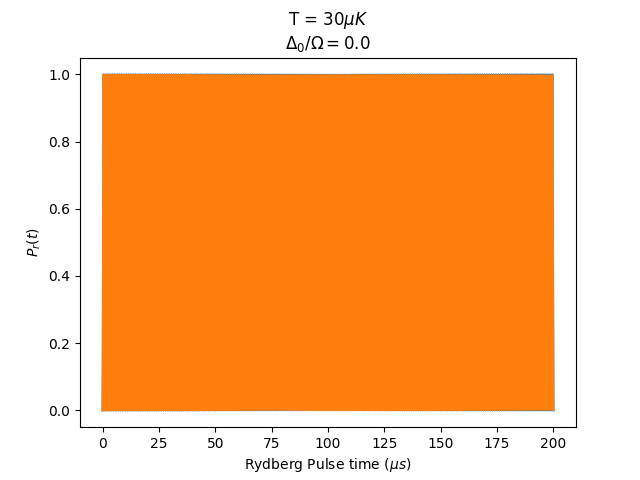

<IPython.core.display.Javascript object>


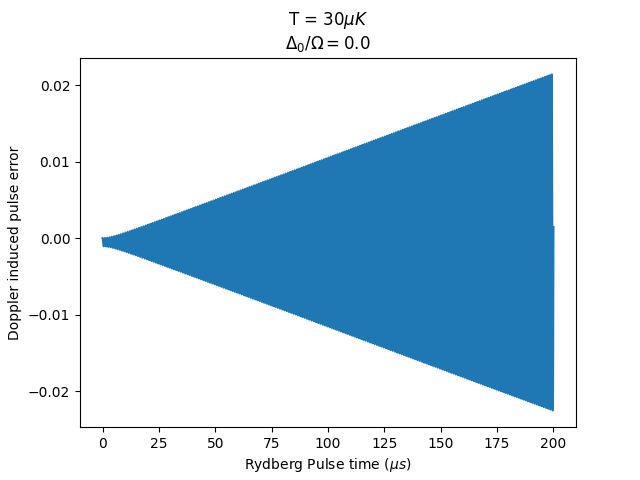

In [7]:
# choice of time points to sample
tlin = linspace(0,200,10000)*tpi

# choice of velocity points to sample
vlin = linspace(-5*sigv,5*sigv,1001)
dv = (max(vlin)-min(vlin))/len(vlin)

# population in rydberg state after pulse-time t, and at atom velocity v
pdens = zeros((len(vlin),len(tlin)),dtype=float)
for i,v in enumerate(vlin):
    pdens[i] = Pr0(tlin,v,D0)*rhov(v,sigv)*dv
pdens.shape

# "integrate" over ensemble by summing over pdens in velocity dimension
Pr = pdens.sum(0)

plot_oscillations(tlin,Pr,D0,T)

## Inducing Axial Breating Mode

The velocity distibution of the atoms can be largely enhanced by inducing a breathing mode along the axial axis. This can be done by rapidly switching the trap depth from a low-depth to a high-depth. The atoms in the trap will then begin oscillating from a state with large spread in positions but relatively low spread in velocity, to a state with relatively low spread in position and large spread in velocity.

At the time of greatest velocity spread, the velocity distribution will continue to be gaussian, with a standard deviation:
$$\sigma_v = \sqrt{\frac{kb T}{mcs}}\sqrt{\frac{U_1}{U_0}} $$

Where $U_0$ is the initial, low, trap depth, and $U_1$ is the final, high, trap depth.

In [8]:
# Trap depths (K)
U0 = 0.6e-3
U1 = 5e-3

# Maxwell-Boltzmann spread in velocity (m/s)
sigv = sqrt(kb*T/mcs)*sqrt(U1/U0)

<IPython.core.display.Javascript object>


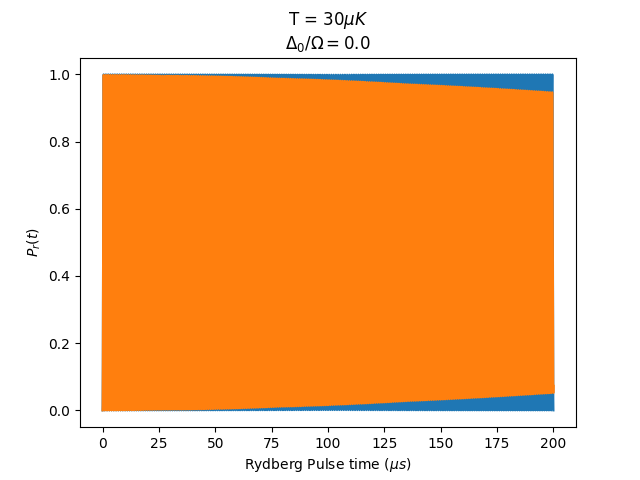

<IPython.core.display.Javascript object>


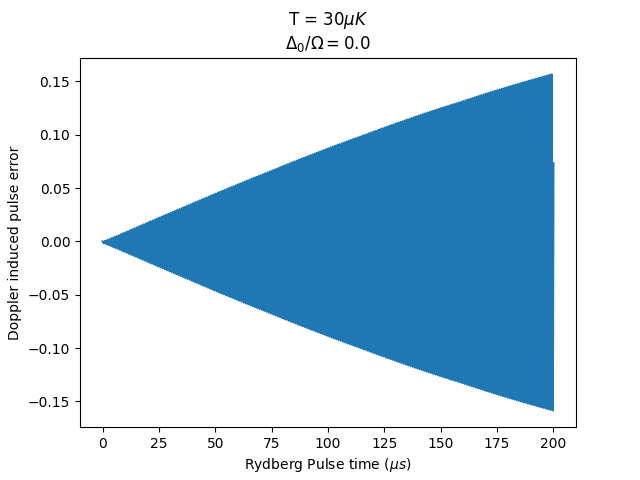

In [9]:
# recompute the damped rabi oscillations with the new velocity spread
# population in rydberg state after pulse-time t, and at atom velocity v
# choice of velocity points to sample
vlin = linspace(-5*sigv,5*sigv,1001)
dv = (max(vlin)-min(vlin))/len(vlin)

pdens = zeros((len(vlin),len(tlin)),dtype=float)
for i,v in enumerate(vlin):
    pdens[i] = Pr0(tlin,v,D0)*rhov(v,sigv)*dv

# "integrate" over ensemble by summing over pdens in velocity dimension
Pr = pdens.sum(0)

plot_oscillations(tlin,Pr,D0,T)

## Increasing detuning sensitivity

We can attempt to increase the sesitivity of the rabi oscillations by detuning the Rydberg beam(s) from the resonance by one Rabi frequency

<IPython.core.display.Javascript object>


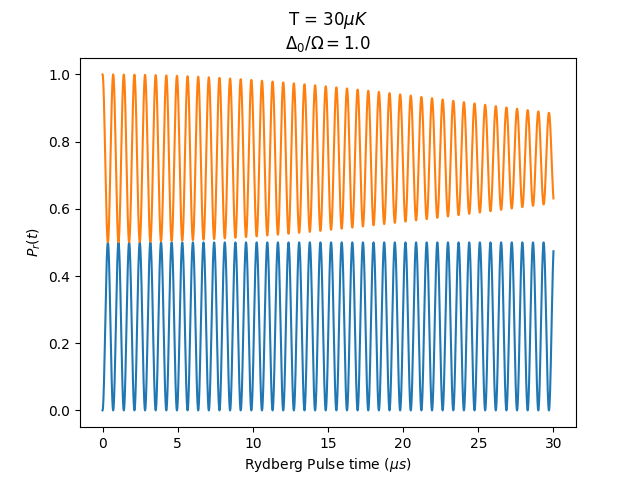

<IPython.core.display.Javascript object>


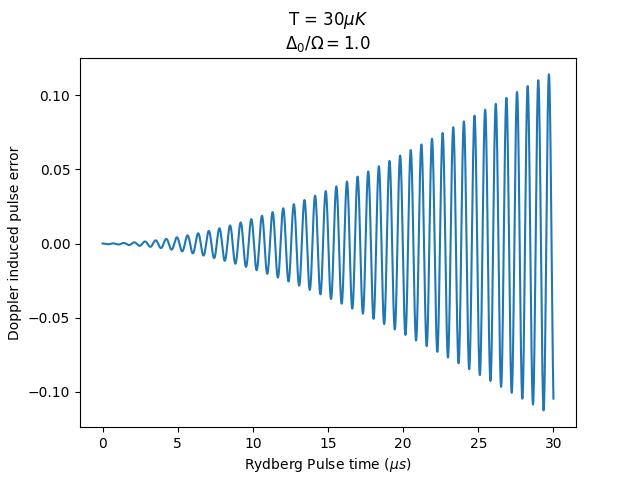

In [11]:
O = tau*1e6 
D0 = O  # increase detuning
tlin = linspace(0,30,10000)*tpi

# Trap depths (K)
U0 = 0.6e-3
U1 = 0.6e-3

# Maxwell-Boltzmann spread in velocity (m/s)
sigv = sqrt(kb*T/mcs)*sqrt(U1/U0)

# recompute the damped rabi oscillations with the new velocity spread
# population in rydberg state after pulse-time t, and at atom velocity v
# choice of velocity points to sample
vlin = linspace(-5*sigv,5*sigv,1001)
dv = (max(vlin)-min(vlin))/len(vlin)

pdens = zeros((len(vlin),len(tlin)),dtype=float)
for i,v in enumerate(vlin):
    pdens[i] = Pr0(tlin,v,D0)*rhov(v,sigv)*dv

# "integrate" over ensemble by summing over pdens in velocity dimension
Pr = pdens.sum(0)

plot_oscillations(tlin,1-Pr,D0,T)

In [177]:
def scramble_phase(x,v,omega):
    if len(x) != len(v):
        raise ValueErrors("x and v must have the same shape")
    
    # determine "energy" of each partical
    r = sqrt(v**2+(omega*x)**2)
    
    # generate array of randomized phases for each particle
    phis = random.rand(len(x))*tau
    
    # conserve energy with random phases
    xf = (r/omega)*cos(phis)
    vf = r*sin(phis)
    
    return xf,vf

Ux = lambda U,x,y,z : -U*exp(-2*(x**2+y**2)/w0**2/(1+z**2/zr**2)) / (1+z**2/zr**2)
Energy = lambda x,y,z,vx,vy,vz: 0.5*mcs*(vx**2+vy**2+vz**2)+Ux(kb*U1,x,y,z)

# function: fun(t,y), t is time, y is all coordinates
# # y = [x,y,vx,vy]
# # dx/dt,dy/dt = vx, vy
# # dvx/dt, dvy/dt = fx/m,fy/m
def newton_2(t,c,U,w):
    def force(x,y,z):
        zr = pi*w**2/938e-9
        lz= 1/(1+z**2/zr**2)
        #print(Ux(U,x,y,z)/w**2/mcs)
        return 4*Ux(U,x,y,z)/w**2 * lz*array([x,y,0.5*z*w**2/zr**2*(1-2*(x**2+y**2)*lz/w**2)])/mcs
    return [*c[3:],*force(*c[0:3])]

In [161]:
N = 1000

w0 = 2.6e-6 # um
zr = pi*w0**2/938e-9

omega_t = sqrt(4*U0*kb/mcs/w0**2) 
omega_a = sqrt(2*U0*kb/mcs/zr**2)

sigxi = sqrt(kb*T/mcs/omega_t**2)
sigzi = sqrt(kb*T/mcs/omega_a**2)
sigvi = sqrt(kb*T/mcs)

rnd = random.default_rng()
xi = rnd.normal(scale=sigxi,size=N)
vxi = rnd.normal(scale=sigvi,size=N)
yi = rnd.normal(scale=sigxi,size=N)
vyi = rnd.normal(scale=sigvi,size=N)
zi = rnd.normal(scale=sigzi,size=N)
vzi = rnd.normal(scale=sigvi,size=N)

omega_tp = omega_t*sqrt(U1/U0)
omega_ap = omega_a*sqrt(U1/U0)

tevolve = linspace(0,pi/omega_ap,100)
tes = [tevolve.min(),tevolve.max()]
args = [U1*kb,w0]

xs = zeros((N,len(tevolve)))
ys = zeros(xs.shape)
zs = zeros(xs.shape)
vxs = zeros(xs.shape)
vys = zeros(xs.shape)
vzs = zeros(xs.shape)
for n in range(N):
    ics = [xi[n],yi[n],zi[n],vxi[n],vyi[n],vzi[n]]
    sol = solve_ivp(newton_2,tes,y0=ics,method="Radau",t_eval=tevolve,args = args)
    xs[n],ys[n],zs[n],vxs[n],vys[n],vzs[n] = sol["y"]

In [162]:
pi

3.141592653589793

In [163]:
drop_times = linspace(0,100,50)*1e-6  # us
Ux = lambda U,x,y,z : -U*exp(-2*(x**2+y**2)/w0**2/(1+z**2/zr**2)) / (1+z**2/zr**2)
Energy = lambda x,y,z,vx,vy,vz: 0.5*mcs*(vx**2+vy**2+vz**2)+Ux(U1*kb,x,y,z)

<IPython.core.display.Javascript object>


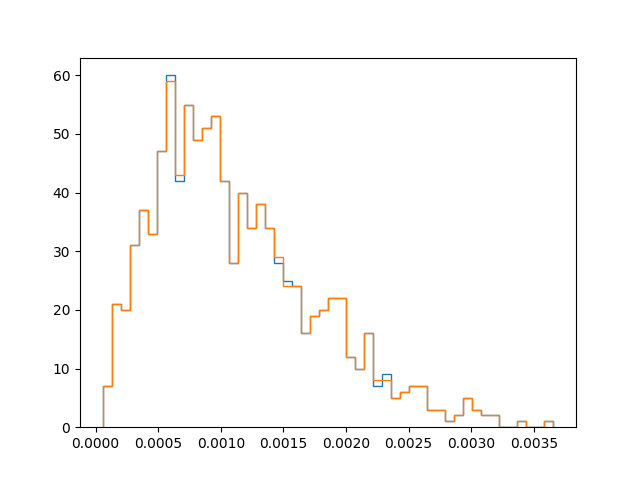

In [164]:
fig,ax = plt.subplots(1,1)
ax.hist(Energy(xs[:,-1],ys[:,-1],zs[:,-1],vxs[:,-1],vys[:,-1],vzs[:,-1])/kb+U1,bins=50,histtype="step")
ax.hist(Energy(xi,yi,zi,vxi,vyi,vzi)/kb+U1,bins=50,histtype="step")
#ax.set_yscale("log")
fig.show()

<IPython.core.display.Javascript object>


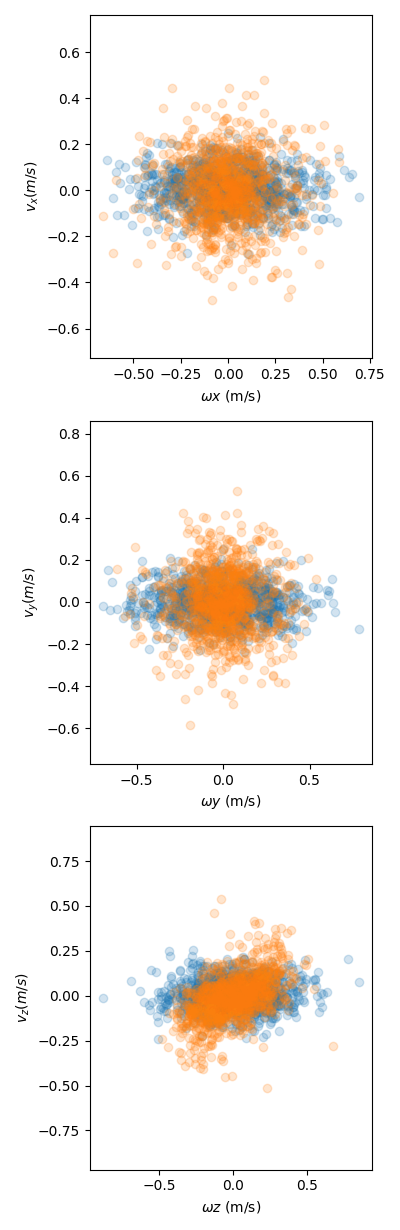

In [179]:
fig,axar = plt.subplots(3,1,figsize=(4,4.1*3))
for a, axis in enumerate("xyz"):
    ax = axar[a]
    if axis == "z":
        omega = omega_ap
    else:
        omega = omega_tp
    pinit,pf,vi,vf = {
        "x": (xi,xs[:,-1],vxi,vxs[:,-1]),
        "y": (yi,ys[:,-1],vyi,vys[:,-1]),
        "z": (zi,zs[:,-1],vzi,vzs[:,-1])
    }[axis]
    ax.scatter(omega*pinit,vi,label="initial",alpha=0.2)
    ax.scatter(omega*pf,vf,label="final",alpha=0.2)
    ax.set_xlabel(f"$\omega {axis}$ (m/s)")
    ax.set_ylabel(f"$v_{axis} (m/s)$")
    ax.set_ylim(*ax.get_xlim())
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


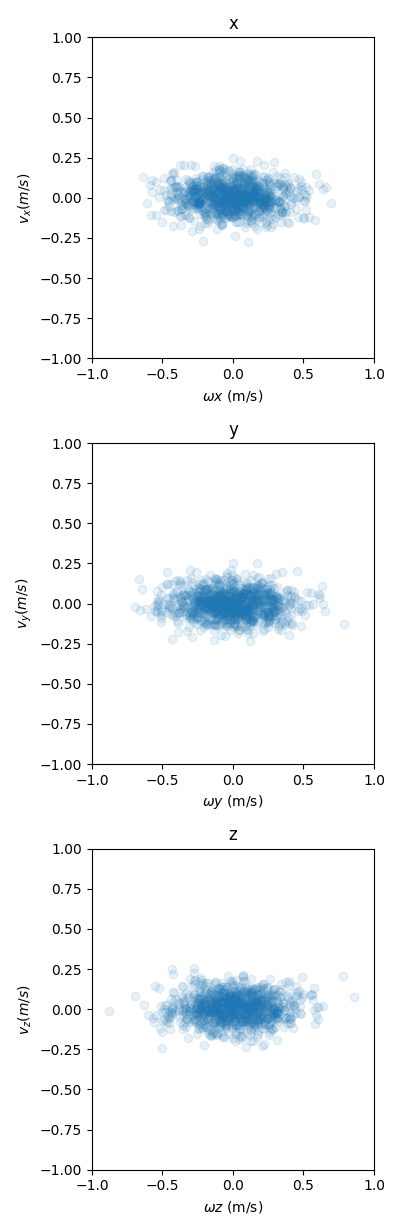

In [180]:
fig,axar = plt.subplots(3,1,figsize=(4,4.1*3))

xvd = {
    "x": (xs,vxs),
    "y": (ys,vys),
    "z": (zs,vzs)
}

omega = {
    "x": omega_tp,
    "y": omega_tp,
    "z": omega_ap
}

def init(scat):
    scat.set_offset([],[])
    return scat,

def update(scats,title,i):
    for j,scat in enumerate(scats):
        axis = "xyz"[j]
        scat.set_offsets(array([omega[axis]*xvd[axis][0][:,i],xvd[axis][1][:,i]]).T)
    return(scats,title)

scats = [axar[j].scatter(omega[axis]*xvd[axis][0][:,0],xvd[axis][1][:,0],alpha=0.1) for j,axis in enumerate("xyz")]

for a, axis in enumerate("xyz"):
    ax=axar[a]
    ax.set_title(axis)
    ax.set_xlabel(f"$\omega {axis}$ (m/s)")
    ax.set_ylabel(f"$v_{axis} (m/s)$")
    ax.set_xlim(-1,1)
    ax.set_ylim(*ax.get_xlim())

title=""
ani=animation.FuncAnimation(fig,lambda i: update(scats,title,i),interval=50,frames=int((len(tevolve)*1.1)//2),repeat=True,repeat_delay=400)
#update(scats,title,len(tevolve)-1)
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


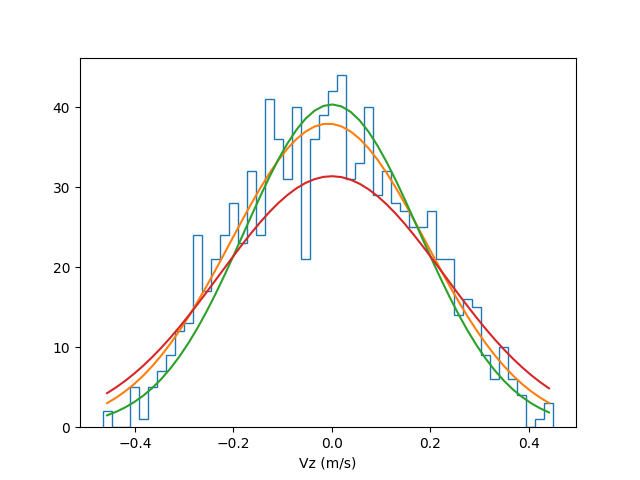

In [167]:
vzm = xvd["z"][1][:,55]

bins = 50
hist, bin_edges = histogram(vzm, bins=bins)
binwidth = (max(bin_edges)-min(bin_edges))/len(bin_edges)

bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

func = lambda x,mu,std,a : a/std/sqrt(tau)*exp(-(x-mu)**2/2/std**2)
guess = [0,sqrt(kb*T/mcs)*sqrt(U1/U0),N]

popt,pcov = curve_fit(func,bin_centers,hist,p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
#ax.scatter(bin_centers,hist)
ax.hist(vzm,bins=bins,histtype="step")
ax.plot(bin_centers,func(bin_centers,*popt))
ax.plot(bin_centers,func(bin_centers,0,vzm.std(),N*binwidth))
ax.plot(bin_centers,func(bin_centers,0,sqrt(kb*T/mcs)*sqrt(U1/U0),N*binwidth))
ax.set_xlabel("Vz (m/s)")
fig.show()

In [168]:
def dr_evolve(dt,x,y,z,vx,vy,vz):
    """
    Time evolution of drop-recapture experiment without gravity
    """
    
    xf = dt*vx+x
    yf = dt*vy+y
    zf = dt*vz+z
    
    return xf,yf,zf,vx,vy,vz

droptimes = linspace(0,200,100)*1e-6  # 0-100 us

tind = 55
x0 = xs[:,tind]
y0 = ys[:,tind]
z0 = zs[:,tind]
vx0 = vxs[:,tind]
vy0 = vys[:,tind]
vz0 = vzs[:,tind]

retention = zeros(len(droptimes))
for i,t in enumerate(droptimes):
    xd,yd,zd,vxd,vyd,vzd = dr_evolve(t,x0,y0,z0,vx0,vy0,vz0)

    recaped = (Energy(xd,yd,zd,vxd,vyd,vzd) < 0).sum()
    retention[i] = recaped/N
    
retf = interp1d(droptimes,retention,kind="quadratic")

<IPython.core.display.Javascript object>


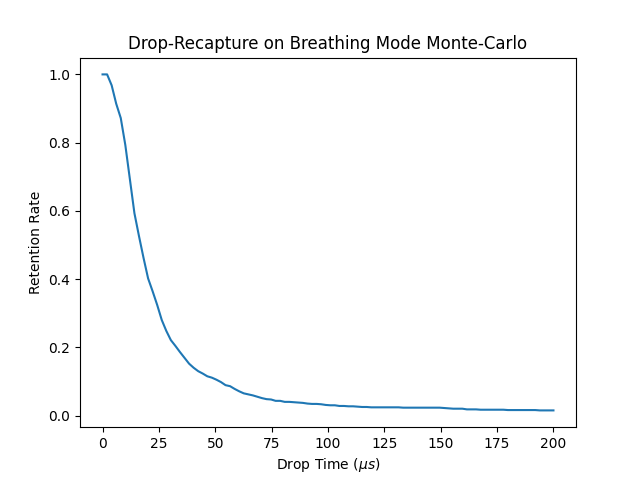

In [169]:
fig,ax=plt.subplots(1,1)
ax.plot(droptimes*1e6,retention)
ax.set_xlabel("Drop Time ($\mu s$)")
ax.set_ylabel("Retention Rate")
ax.set_title("Drop-Recapture on Breathing Mode Monte-Carlo")
fig.show()

<IPython.core.display.Javascript object>


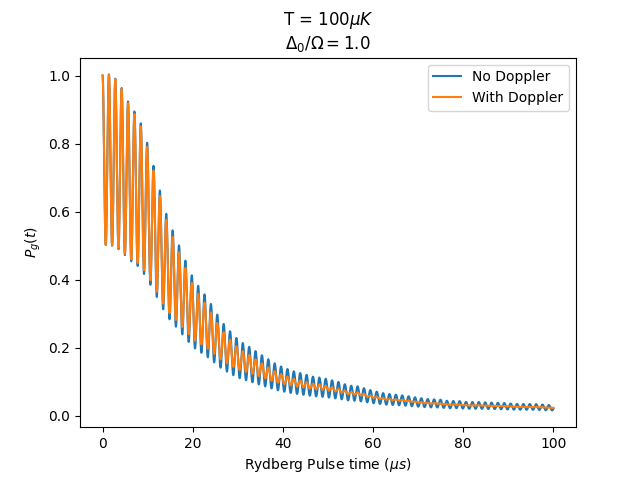

<IPython.core.display.Javascript object>


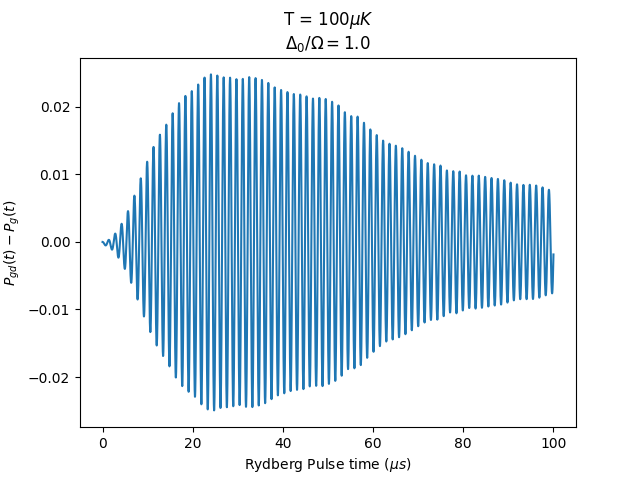

In [185]:
O = tau*0.5e6
D0 = O  # increase detuning
tlin = linspace(0,10,10000)*tpi

# Trap depths (K)
U0 = 0.6e-3
U1 = 5e-3

# Maxwell-Boltzmann spread in velocity (m/s)
sigv = sqrt(kb*T/mcs)*sqrt(U1/U0)

# recompute the damped rabi oscillations with the new velocity spread
# population in rydberg state after pulse-time t, and at atom velocity v
# choice of velocity points to sample
vlin = linspace(-5*sigv,5*sigv,1001)
dv = (max(vlin)-min(vlin))/len(vlin)

pdens = zeros((len(vlin),len(tlin)),dtype=float)
for i,v in enumerate(vlin):
    pdens[i] = Pr0(tlin,v,D0)*rhov(v,sigv)*dv

# "integrate" over ensemble by summing over pdens in velocity dimension
Pr = pdens.sum(0)

title = f"T = {T*1e6:.0f}$\mu K$\n$\Delta_0/\Omega = {D0/O:.1f}$"
xlabel = "Rydberg Pulse time ($\mu s$)"

fig,ax=plt.subplots(1,1)
Pg = (1-Pr)*retf(tlin)
Pgc = (1-Pr0(tlin,0,Delta0=D0))*retf(tlin)
ax.plot(tlin*1e6,Pgc,label="No Doppler")
ax.plot(tlin*1e6,Pg,label="With Doppler")
ax.legend()
#ax.set_xlim(0,20)

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel("$P_g(t)$")
fig.show()

fig,ax=plt.subplots(1,1)
Pg = (1-Pr)*retf(tlin)
Pgc = (1-Pr0(tlin,0,Delta0=D0))*retf(tlin)
ax.plot(tlin*1e6,Pgc-Pg)
#ax.legend()
#ax.set_xlim(0,20)

ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel("$P_{gd}(t)-P_g(t)$")
fig.show()


In [112]:
def plot_oscillations(t,pr,delta0,temp):
    title = f"T = {temp*1e6:.0f}$\mu K$\n$\Delta_0/\Omega = {delta0/O:.1f}$"
    xlabel = "Rydberg Pulse time ($\mu s$)"
    fig,ax = plt.subplots(1,1)
    ax.plot(t*1e6,Pr0(t,0,delta0))
    ax.plot(t*1e6,pr)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("$P_r(t)$")
    fig.show()

    fig,ax = plt.subplots(1,1)
    ax.plot(tlin*1e6,Pr-Pr0(tlin,0,delta0))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Doppler induced pulse error")
    fig.show()

array([0.00000000e+00, 1.00010001e-08, 2.00020002e-08, ...,
       9.99799980e-05, 9.99899990e-05, 1.00000000e-04])

In [113]:
max(droptimes)

0.00019999999999999998

In [114]:
max(tlin)

0.0001